In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

from scipy.stats.mstats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from scipy.stats import sem

from nilearn.signal import clean

In [2]:
os.chdir('../')

In [3]:
# loa my modules
from src.PMA_SCCA import SCCA
from src.utils import load_pkl
from src.visualise import *
from src.file_io import save_output

In [4]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
# load data
dataset = load_pkl(dat_path)

In [5]:
FC_yeo7 = dataset['FC_Yeo7']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']
confound_raw = np.hstack((mot, sex, age))

In [6]:
out_folds = 5
in_folds = 4
para_x, para_y = 9, 9
n_selected = 4
param_setting = {
    'reg_X': np.array(range(1, para_x + 1)) * 0.1,
    'reg_Y': np.array(range(1, para_y + 1)) * 0.1,}

# Cleaning confounds

We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.

In [7]:
def clean_confound(RS, COG, confmat):

    # regress out confound
    z_confound = zscore(confmat)
    # squared measures to help account for potentially nonlinear effects of these confounds
    z2_confound = z_confound ** 2
    conf_mat = np.hstack((z_confound, z2_confound))

    # clean signal
    RS_clean = clean(np.arctanh(RS), confounds=conf_mat, detrend=False, standardize=False)
    COG_clean = clean(zscore(COG), confounds=conf_mat, detrend=False, standardize=False)

    return RS_clean, COG_clean, conf_mat

# K-Fold CV for parameters/model selection

In [8]:
KF_out = KFold(n_splits=out_folds, shuffle=True, random_state=42)
KF_in = KFold(n_splits=in_folds, shuffle=True, random_state=42)
param_grid = ParameterGrid(param_setting)

## Penalty selection CV

Grid search range, set up inner and outer folds and the parameter grid

In [9]:
def parameter_grid(para, para_fn):
    i = np.argmin(para)
    d_idx = np.unravel_index(i, para.shape)
    
    title = 'Sparsity Parameter Search'
    hm = plt.matshow(para.T, vmin=0, vmax=0.5, cmap="inferno_r")
    plt.xticks(range(9), np.array(range(1, 10)) * 0.1)
    plt.yticks(range(9), np.array(range(1, 10)) * 0.1)
    plt.xlabel('Connectivity')
    plt.ylabel('MRIQ')
    plt.title(title)
    plt.colorbar(hm, label='CV Estimate of Prediction Error')
    # Create a Rectangle patch
    rect = patches.Rectangle(np.array(d_idx) - 0.5, 1, 1,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    hm.axes.add_patch(rect)
    hm.axes.xaxis.set_ticks_position('bottom')
    plt.savefig(para_fn, dpi=300)
    plt.show()
    plt.close()

    return d_idx

==Train-test split 1/5==


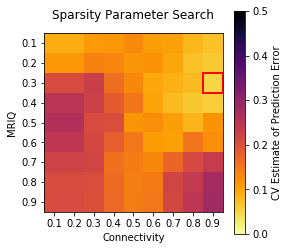


Best parameters based on discovery set cross-validation:[ 0.9  0.3]
Test error:0.0526127682968
==Train-test split 2/5==


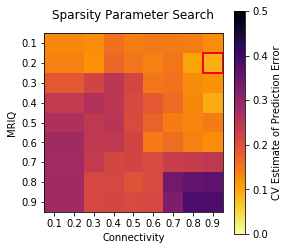


Best parameters based on discovery set cross-validation:[ 0.9  0.2]
Test error:0.0406424603374
==Train-test split 3/5==


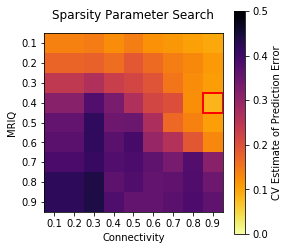


Best parameters based on discovery set cross-validation:[ 0.9  0.4]
Test error:0.0184755532792
==Train-test split 4/5==


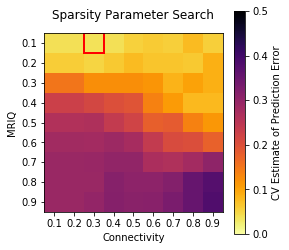


Best parameters based on discovery set cross-validation:[ 0.3  0.1]
Test error:0.0210482296106
==Train-test split 5/5==


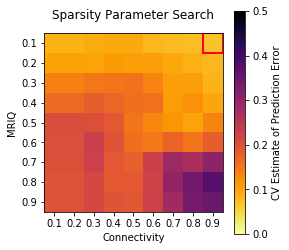


Best parameters based on discovery set cross-validation:[ 0.9  0.1]
Test error:0.0602660614757

Best parameters based on outer fold results: X-0.9; Y-0.4
Final test error: 0.0184755532792


In [10]:
best_model = None
best_generr = 1
para_search = np.zeros((para_x, para_y, out_folds))

for i, (train_idx, test_idx) in enumerate(KF_out.split(FC_yeo7)):
    print('==Train-test split {0:}/{1:}=='.format(i + 1, out_folds))
    X_discovery, X_test = FC_yeo7[train_idx], FC_yeo7[test_idx]
    Y_discovery, Y_test = MRIQ[train_idx], MRIQ[test_idx]
    conf_discovery, conf_test = confound_raw[train_idx], confound_raw[test_idx]

    para_mean = np.zeros((para_x, para_y))
    for j, parameters in enumerate(iter(param_grid)):
        para_idx = np.unravel_index(j, para_mean.shape) # (C_x,C_y, K)
        model = SCCA(n_components=n_selected, scale=True, n_iter=50,
                     penX=parameters['reg_X'], penY=parameters['reg_Y'],
                    )
        j_model = None
        dj_list = []
        for k, (train_idx, test_idx) in enumerate(KF_in.split(X_discovery)):

            # find best weights for this hyper parameter set
            X_train, X_confirm = X_discovery[train_idx], X_discovery[test_idx]
            Y_train, Y_confirm = Y_discovery[train_idx], Y_discovery[test_idx]
            conf_train, conf_confirm = conf_discovery[train_idx], conf_discovery[test_idx]

            X_train_clean, Y_train_clean, confmat_train_clean = clean_confound(
                                        X_train, Y_train, conf_train)
            X_confirm_clean, Y_confirm_clean, conf_confirm_clean = clean_confound(
                            X_confirm, Y_confirm, conf_confirm)

            model.fit(X_train_clean, Y_train_clean)
            # use the mean variance explained to select the best parameter set
            d_orig = (model.cancorr_ ** 2).sum()
            d_k = (model.score(X_confirm_clean, Y_confirm_clean) ** 2).sum()
            # loss function
            error_k = np.abs(d_orig - d_k)
            
            dj_list.append(error_k)

        para_mean[para_idx] = np.mean(dj_list)
        
    # plot the model search of current fold
    para_fn = './reports/revision/cv-fold{:}.png'.format(i + 1)
    d_idx = parameter_grid(para_mean, para_fn)
    C = 0.1 * (np.array(d_idx) + 1)

    # tune the model and apply test set on the final model
    X_discovery_clean, Y_discovery_clean, conf_discovery_clean = clean_confound(X_discovery, Y_discovery, conf_discovery)
    X_test_clean, Y_test_clean, conf_test_clean = clean_confound(X_test, Y_test, conf_test)
    i_model = SCCA(n_components=n_selected, scale=True, n_iter=50,
                     penX=C[0], penY=C[1],
                    )
    i_model.fit(X_discovery_clean, Y_discovery_clean)
    di_orig = (i_model.cancorr_ ** 2).sum()
    di = (i_model.score(X_test_clean, Y_test_clean) ** 2).sum()
    pred_error = np.abs(di_orig - di)

    print('Test error:{:}'.format(pred_error))    
    
    if pred_error < best_generr:
        best_generr = pred_error
        best_model = copy.deepcopy(i_model)
    para_search[..., i] = para_mean

# final parameter
print('\nBest parameters based on outer fold results: X-{:}; Y-{:}'.format(best_model.penX, best_model.penY))
print('Final test error: {}'.format(best_generr))

In [11]:
X, Y, _ = clean_confound(FC_yeo7, MRIQ, confound_raw)
best_model.fit(X, Y)
joblib.dump(best_model, 
            './models/SCCA_Yeo7_{:1d}_{:.2f}_{:.2f}.pkl'.format(
                best_model.n_components, best_model.penX, best_model.penY))

set_text_size(12)
u, v = best_model.u, best_model.v

figs = show_results(u, v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)

write_pdf('./reports/revision/bestModel_confoundclean_collection_nested_{0:1d}_{1:.1f}_{2:.1f}_.pdf'.format(
                best_model.n_components, best_model.penX, best_model.penY), figs)

In [12]:
X_scores, Y_scores, df_z = save_output(dataset, best_model, X, Y, path=None)

In [13]:
df_z.to_csv('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))